In [0]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
import math
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch.nn.init as init

In [0]:
def f_cosexp(x):
  return np.cos(np.pi/2*x)*np.exp(-(x/2)**2)

def f_linear(x):
  return 0.5*x

def f_step(x):

  n = x.shape[0]
  t = np.zeros(shape=(n,1))
  for i in range(n):
    if x[i] < -1:
      t[i] = -1.0
    elif x[i] < 1:
      t[i] = 1.0
    else: t[i] = -1.0
  return t

def data4reg(_type='', _n=1000, _oRange=[-1.5,1.5], _oRate=0.1, measVar=0.01):
  np.random.seed(seed=0)
  _xmin,_xmax = -3,3

  x = np.double(np.random.uniform(_xmin,_xmax,((int)(_n),1)))
  x.sort(axis=0)

  if _type == 'cosexp': t = f_cosexp(x)
  elif _type == 'linear': t = f_linear(x)
  elif _type == 'step': t = f_step(x)
  else: print ("Unknown function type [%s]."%(_type))
    # Add measurement nosie
  y = t + np.sqrt(measVar)*np.random.randn(_n,1)
    # Switch to outliers 
  nOutlier = (int)(_n*_oRate) # Number of outliers
  y[np.random.permutation((int)(_n))[:nOutlier],:] = _oRange[0]+np.random.rand(nOutlier,1)*(_oRange[1]-_oRange[0])
  
  return x,y,t

def plot_1dRegData(_x,_y,_t,_type='',_figSize=(6,3)):
    plt.figure(figsize=_figSize) # Plot
    # ht,=plt.plot(_x,_t,'ro')
    hd,=plt.plot(_x,_y,'k.')
    # plt.legend([ht,hd],['Target function','Training data'],fontsize=15)
    plt.title('%s'%(_type),fontsize=18)
    plt.show()

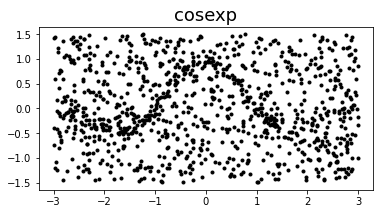

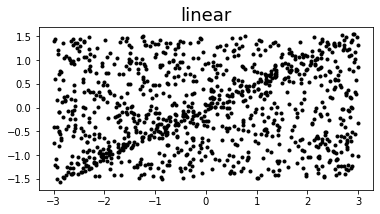

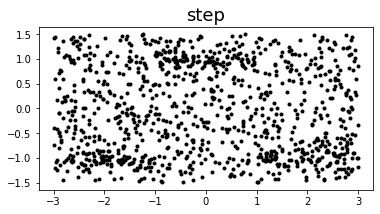

In [23]:
if __name__ == "__main__":
    for tIdx,_type in enumerate(['cosexp','linear','step']):
        _x,_y,_t=data4reg(_type=_type,_n=1000,_oRange=[-1.5,+1.5],_oRate=0.8,measVar=1e-2)
        plot_1dRegData(_x,_y,_t,_type)

In [0]:
class ChoiceNet(nn.Module):
  def __init__(self, x_dim, y_dim, num_mixture, feature_dim, logSigmaZval, tau_inv, pi1_bias):
    super(ChoiceNet,self).__init__()
    #self.backbone = backbone
    self.y_dim = y_dim
    self.num_mixture = num_mixture
    self.feature_dim = feature_dim
    self.logSigmaZval = logSigmaZval
    self.tau_inv = tau_inv
    self.pi1_bias = pi1_bias
    #self.rho_ref = rho_ref
    #self.USE_GAT = USE_GAT
    self.Q = self.feature_dim
    #self.ResBlock = ResBlock()

    self.back_bone = nn.Sequential(
        nn.Linear(1,32),
        nn.Linear(32,self.feature_dim) 
    )
    
    self.fc_rho_raw = nn.Linear(self.feature_dim,self.num_mixture)
    # self.fc_feature_dim = nn.Linear(7*7*64, self.feature_dim)
    # self.fc_num_mixture = nn.Linear(self.feature_dim, num_mixture)

    self.fc_var_raw = nn.Linear(self.feature_dim, self.y_dim)

    self.fc_pi_logits = nn.Linear(self.feature_dim, self.num_mixture)

    self.tanh1 = nn.Tanh()
   
    self.softmax1 = nn.Softmax(dim=1)

    self.softmax2 = nn.Softmax(dim=1)

    self.muW = torch.randn(size=(self.Q, self.y_dim), requires_grad=True)
    self.logSigmaW = -2.0*torch.ones(size=(self.Q, self.y_dim), requires_grad=True)
    self.muZ = torch.zeros(self.Q, self.y_dim) # Q*D

    self.logSigmaZ = init.constant(torch.FloatTensor(self.Q, self.y_dim), self.logSigmaZval)


    #self.muZ = torch.zeros(size=(self.Q, self.y_dim), requires_grad=True)
    #self.mu_layer = nn.Linear(self.feature_dim, self.y_dim)
    #self.sigma_layer = nn.Linear(self.feature_dim, self.y_dim)

    # self.muW = init.normal(torch.FloatTensor(self.Q, self.y_dim), std=0.1)
    # self.muW.requires_grad=True

    # self.logSigmaW = init.constant(torch.FloatTensor(self.Q, self.y_dim),-2.0)
    # self.logSigmaW.requires_grad=True

    # self.muZ = torch.zeros(self.Q, self.y_dim) # Q*D
    # self.muZ.requires_grad=True

    # self.logSigmaZ = init.constant(torch.FloatTensor(self.Q, self.y_dim), self.logSigmaZval)
    # self.logSigmaZ.requires_grad=True
    
  def forward(self, x, rho_ref):
    self.rho_ref = rho_ref
    x = self.back_bone(x)
    self.feature = x

    #with torch.enable_grad():
    rho_raw = self.fc_rho_raw(x)
    self.rho_temp = self.tanh1(rho_raw)
      #self.rho_temp = F.tanh(rho_raw)
    self.rho = torch.cat([self.rho_temp[:,0:1]*0.0 + self.rho_ref, self.rho_temp[:, 1:]], axis=1)

      #print('rho_raw : ',rho_raw)
      #print('rho_temp : ',rho_temp)
      
    self.num_data = x.size()[0]
    ############################################################
    #muW_x = init.normal(torch.FloatTensor(self.Q, self.y_dim), std=0.1)
    #sigmaW_x = init.constant(torch.FloatTensor(self.Q, self.y_dim),-2.0)

    # muw = self.mu_layer(self.feature)
    # sigmaw = self.sigma_layer(self.feature)

    # epsw = torch.randn(self.num_data, self.Q, self.y_dim, dtype=torch.float)
    

    ############################################################
    #muW_x = init.normal(torch.FloatTensor(self.Q, self.y_dim), std=0.1)
    #sigmaW_x = init.constant(torch.FloatTensor(self.Q, self.y_dim),-2.0)

    #muW_x = torch.randn(size=(self.Q, self.y_dim), requires_grad=True)

    #W = self.sampling(muW_x, sigmaW_x)#Q*D


    ############################################################
    #make_sample
    muW_tile, muZ_tile, sigmaW_tile, sigmaZ_tile = self.make_sample() 
      
    # cholesky #[K*N*Q*D] #W_bar
    #branch_2
    samplerList = self.cholesky(muW_tile, sigmaW_tile, muZ_tile, sigmaZ_tile)#K*N*Q*D
    wSample = samplerList.permute(1,3,0,2) #[N*D*K*Q]

    #K mean mixtures
    wTemp = wSample.contiguous().view(self.num_data, self.num_mixture*self.y_dim, self.Q) #W~_k
    featRsh = self.feature.view(self.num_data, self.Q, 1)
    _mu = torch.matmul(wTemp, featRsh) #[N*DK*1]
    self.mu = _mu.view(self.num_data, self.y_dim, self.num_mixture)

    #K var mixtures #(6) 
    #branch_3
    logvar_raw = self.fc_var_raw(self.feature) #[N*D]
    var_raw = torch.exp(logvar_raw)
      #print('logvar_raw:',logvar_raw)
    var_tile = var_raw.unsqueeze(-1).repeat(1, 1, self.num_mixture) #N*D*K
    rho_tile = self.rho.unsqueeze(1).repeat(1, self.y_dim, 1)#N,D,K
    tau_inv = self.tau_inv
    self.var = (1.0 - torch.pow(rho_tile,2))*var_tile + tau_inv
    #print('var_req : ',self.var.requires_grad)

    # Weight allocation probability pi [N*K] # pi_k = softmax()_k
    #branch_1
    pi_logits = self.fc_pi_logits(self.feature) #[N*K]
    self.pi_temp = self.softmax1(pi_logits)
    #self.pi_temp = F.softmax(pi_logits, dim=1)
    if self.pi1_bias != 0:
      self.pi_temp = torch.cat((pi_temp[:, 0:1] + self.pi1_bias, self.pi_temp[:, 1:]), axis=1)
      self.pi = self.softmax2(self.pi_temp)
    else: self.pi = self.pi_temp

    #print('muw',self.muW)
    return self.rho, self.mu, self.var, self.pi

  def sampling(self, mean, var):

    # Reparameterization trick for back-propagation
    mean, log_var = mean, var
    epsilon = torch.randn(self.num_data, self.Q, self.y_dim, dtype=torch.float)

    return mean + torch.exp(log_var) * epsilon
    

  def make_sample(self):
    
    # self.muW = torch.randn(size=(self.Q, self.y_dim), requires_grad=True)
    # self.logSigmaW = -2.0*torch.ones(size=(self.Q, self.y_dim), requires_grad=True)
    # self.muZ = torch.zeros(self.Q, self.y_dim) # Q*D
    # self.logSigmaZ = init.constant(torch.FloatTensor(self.Q, self.y_dim), self.logSigmaZval)


    #self.muW = init.normal(torch.FloatTensor(self.Q, self.y_dim), std=0.1)
    #self.muW.requires_grad=True
    #print(self.muW)
    #self.logSigmaW = init.constant(torch.FloatTensor(self.Q, self.y_dim),-2.0)
    #self.logSigmaW.requires_grad=True

    
    #self.muZ.requires_grad=True

    
    #self.logSigmaZ.requires_grad=True

    N = self.num_data

    muW = self.muW

    logSigmaW = self.logSigmaW

    muZ = self.muZ # Q*D
    
    logSigmaZ = self.logSigmaZ 

    muW_tile = muW.unsqueeze(0).repeat(N,1,1) # N*Q*D
    sigmaW_tile = torch.exp(logSigmaW.unsqueeze(0).repeat(N,1,1)) #N*Q*D
    
    muZ_tile = muZ.unsqueeze(0).repeat(N,1,1)
    sigmaZ_tile = torch.exp(logSigmaZ.unsqueeze(0).repeat(N,1,1))

    return muW_tile, muZ_tile, sigmaW_tile, sigmaZ_tile

  def cholesky(self,muW_tile, sigmaW_tile, muZ_tile, sigmaZ_tile):
    samplerList = []
    for mix_idx in range(self.num_mixture):
      rho_j = self.rho[:, mix_idx : mix_idx+1] # N*1
      rho_tile = rho_j.unsqueeze(-1).repeat(1, self.Q, self.y_dim) # N*Q*D
      
      epsW = torch.randn(self.num_data, self.Q, self.y_dim, dtype=torch.float) #mean=0, std=1
      W = muW_tile + torch.sqrt(sigmaW_tile)*epsW
      
      epsZ = torch.randn(self.num_data, self.Q, self.y_dim, dtype=torch.float)
      Z = muZ_tile + torch.sqrt(sigmaZ_tile)*epsZ

      #Cholesky
      Y = rho_tile*muW_tile + (1.0 - torch.pow(rho_tile,2))\
                               *(rho_tile*torch.sqrt(sigmaZ_tile)/torch.sqrt(sigmaW_tile)\
                                 *(W - muW_tile) + Z*torch.sqrt(1 - torch.pow(rho_tile,2)))
                               
      #print('Y: ' ,Y)
      samplerList.append(Y)
    return torch.stack(samplerList)


In [0]:
def sampler(model, _x, y_dim, num_mixture, n_samples=1, _deterministic=False):
  model.train(False)
  rho, mu, var, pi= model(_x,rho_ref=1)
  n_points = _x.shape[0]
  _y_sampled = torch.zeros([n_points, y_dim, n_samples])

  #print('mu',mu)
  #print('pi',pi)
  for i in range(n_points):
    for j in range(n_samples):
      if _deterministic: k=0
      else: k=np.random.choice(num_mixture,size=1, p=pi[i,:].view(-1).detach().numpy())
      #print(pi[i,:].view(-1).detach().numpy(), k)
      _y_sampled[i,:,j] = mu[i,:,k]
      
  return _y_sampled

In [0]:
def train(model,_x,_y,_yref='',lr=1e-3,batchSize=512,maxEpoch=1e4,kp=1.0):
  model.train()

  _x_train, _y_train = torch.from_numpy(_x),torch.from_numpy(_y)

  maxIter = max(_x_train.shape[0]//batchSize,1)
  bestLossVal = np.inf
  for epoch in range((int)(maxEpoch)+1):
    train_rate = (float)(epoch/maxEpoch)
    _x_train,_y_train = shuffle(_x_train,_y_train)

    x_train, y_train = Variable(_x_train),Variable(_y_train)

    for iter in range(maxIter):
      start, end = iter*batchSize,(iter+1)*batchSize

      lr_use = lr

      optimizer.zero_grad()
      model = model.double()
      rho, mu, var, pi = model(x_train,rho_ref=0.95)
      #print('rho : ',rho,'\nmu : ', mu,'\nvar :' ,var,'\npi : ', pi)
      loss = MDNloss(len(x_train), rho, mu, var, pi, y_train, y_dim=1, num_mixture=5, logsumexp_coef= 1e-2, kl_reg_coef= 1e-4,train_rate=train_rate).forward()
      
      loss.backward(retain_graph=True)
      print(loss)
      #print(acc)

      optimizer.step()

      nSample = 1
      ytest = sampler(model, _x=_x_train, y_dim=1,num_mixture=5, n_samples=1, _deterministic=True)
      #print(ytest)
      ytest = ytest.detach().numpy()
      x_plot, y_plot = _x[:,0], _y[:,0]
      plt.figure(figsize=(8,4))
      plt.axis([np.min(x_plot), np.max(x_plot), np.min(y_plot)-0.1, np.max(y_plot)+0.1])

      if _yref != '':
        plt.plot(x_plot,_yref[:,0],'r')
      plt.plot(x_plot, y_plot, 'k.')

      for i in range(nSample):
        plt.plot(_x,ytest[:,0,i],'b.')
      plt.title("[%d%d] name:[%s] lossVal:[%.3e]"%(epoch,maxEpoch,'gg',loss.item()))
      plt.show()

      # if batch_idx%args['log_interval'] == 0:
      #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #       epoch, batch_idx * len(data), len(train_loader.dataset),
      #       100. *batch_idx/len(train_loader), loss.data
      #   ))


In [0]:
class MDNloss(nn.Module):
  def __init__(self, num_data, rho, mu, var, pi, target, y_dim, num_mixture, logsumexp_coef, kl_reg_coef, train_rate):
    super(MDNloss, self).__init__()
    self.num_data = num_data
    self.rho = rho #N*K
    self.mu = mu #N*D*K
    self.var = var #N*D*K
    self.pi = pi #N*K
    self.target = target
    self.y_dim = y_dim
    self.num_mixture = num_mixture
    self.logsumexp_coef = logsumexp_coef
    self.kl_reg_coef = kl_reg_coef
    self.train_rate = train_rate
    self.var_eps = 1e-2

    #print(self.var)

    #self.yhat = self.mu + torch.sqrt(self.var)*torch.randn(self.num_data, self.y_dim, self.num_mixture)

  def forward(self):

    self.oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*math.pi)
                                         
    M = self.num_data
    #t,pi,mu,var = self.target, self.pi, self.mu, self.var

    trepeat = self.target.unsqueeze(-1).repeat(1, 1, self.num_mixture)
    self.quadratics = -0.5*torch.sum(torch.pow((trepeat-self.mu),2)/(self.var+self.var_eps),axis=1)
    self.logdet = -0.5*torch.sum(torch.log(self.var+self.var_eps),axis=1)
    self.logconstant = -0.5*self.y_dim*torch.log(2*self.pi)
    self.logpi = torch.log(self.pi)
    self.exponents = self.quadratics + self.logdet + self.logpi
    self.logprobs = torch.logsumexp(self.exponents,axis=1)
    self.gmm_prob = torch.exp(self.logprobs)
    self.gmm_nll = -torch.mean(self.logprobs)
    ################################################################
    #print(self.mu.size())  1000,1,5
    self.mu_bar = self.gather()
    #print(self.mu_bar.size()) 200,5

    mu1 = self.mu[:,:,0]
    fit_mse_coef = 1e-2
    self.fit_mse = fit_mse_coef*self.max((1.0-2.0*self.train_rate),0.0)*torch.sum(torch.pow(self.mu_bar-self.target,2))/float(self.num_data)

    MSEloss = nn.MSELoss()
    
    MSE_out = MSEloss(mu1, self.target)

    MDN_out = self.mdn_loss_fn(self.pi,self.mu,self.var,self.target)

    _eps = 1e-2
    self.rho_pos = self.rho+1.0
    self._kl_reg = self.kl_reg_coef * torch.sum(-self.rho_pos*(torch.log(self.pi+_eps)-torch.log(self.rho_pos+_eps)),axis=1)
    self.kl_reg = torch.mean(self._kl_reg)
    
    # prob = self.pi*self.g_p(self.var,self.mu,self.target)
    # nll = -torch.log(torch.sum(prob,dim=1))

    #acc = self.acc()
    #print(type(self.gmm_nll), self.gmm_nll.size())
    #print(type(MSE_out), MSE_out.size())

    #return self.gmm_nll + self.kl_reg +self.fit_mse
    return MSE_out+MDN_out
  
  
  
  def gaussian_distribution(self, y, mu, sigma):
    result = (y.unsqueeze(-1).expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(torch.sqrt(sigma))) * self.oneDivSqrtTwoPI

  def mdn_loss_fn(self, pi, mu, sigma, y):
    result = self.gaussian_distribution(y, mu, sigma) * pi
    print(result.size())
    result = torch.sum(result, dim=2)
    print(result.size())
    result = -torch.log(result)
    return torch.mean(result)

  def max(self,a,b):
    if a >= b: return a
    else: return b
  def gather(self):
    arg_pi = torch.argmax(self.pi,dim=1)#1000*1
    
    k = []
    for idx_n in range(self.num_data):#1000
      l = []
      for idx_d in range(self.y_dim):#1
        k.append(self.mu[idx_n][idx_d][arg_pi[idx_n]])
    return torch.stack(k).view(-1,self.y_dim)

  def acc(self):
    #print(self.pi)
    y = self.yhat[:,:,0] #N*D
    #print('y',torch.argmax(y,dim=1))
    #print('target',torch.argmax(self.target,dim=1))
    acc = (torch.argmax(y,dim=1) == torch.argmax(self.target,dim=1)).sum().item()/y.size()[0]

    return acc
    #self.target #N*D

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


back_bone.0.weight True
back_bone.0.bias True
back_bone.1.weight True
back_bone.1.bias True
fc_rho_raw.weight True
fc_rho_raw.bias True
fc_var_raw.weight True
fc_var_raw.bias True
fc_pi_logits.weight True
fc_pi_logits.bias True
torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(7.0360, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


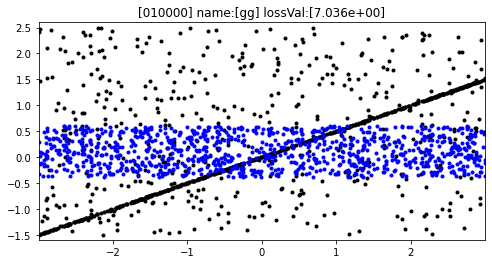

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(5.2921, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


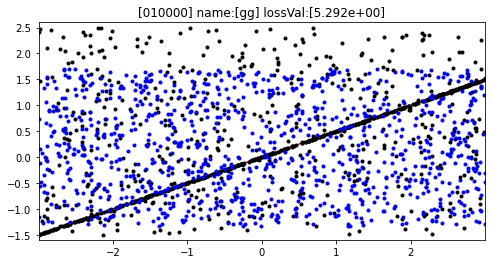

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(5.2864, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


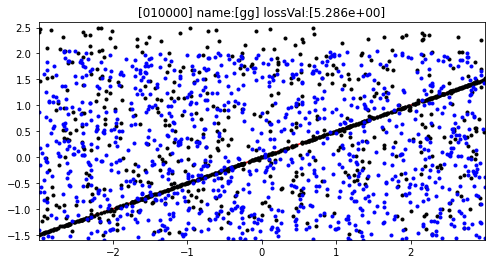

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(5.2092, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


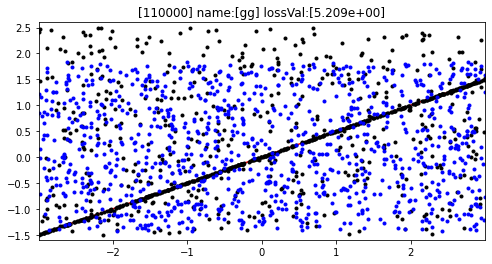

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(5.0039, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


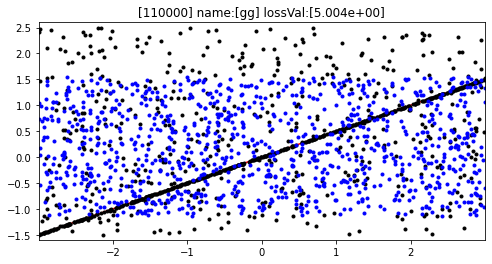

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.3516, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


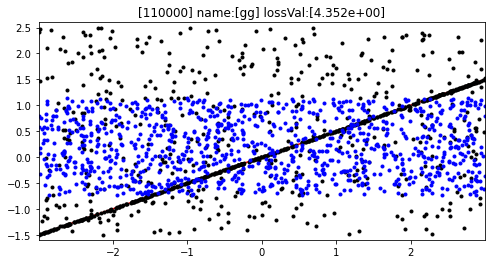

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.4212, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


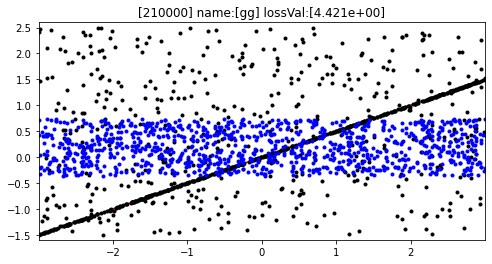

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.2625, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


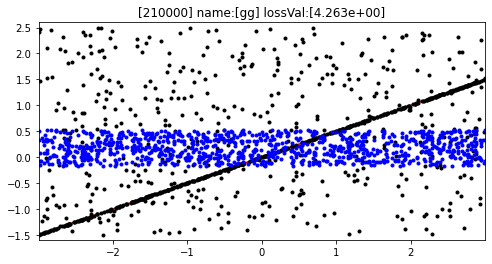

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.4235, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


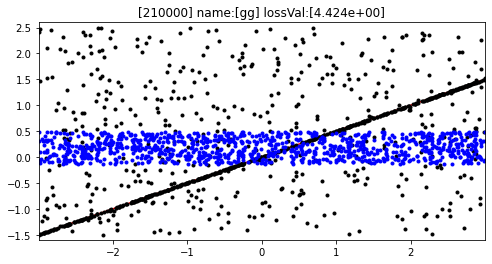

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.1853, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


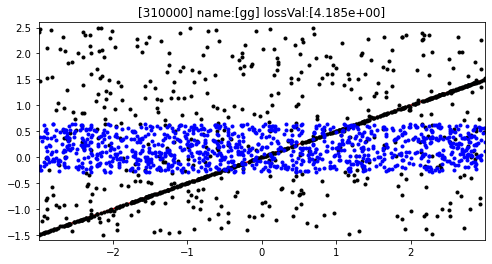

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.1798, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


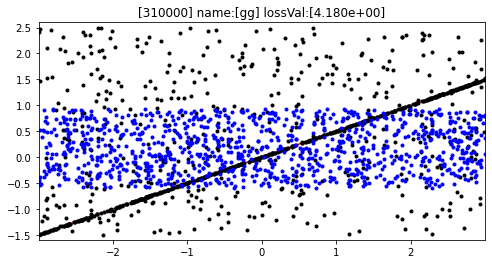

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.0932, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


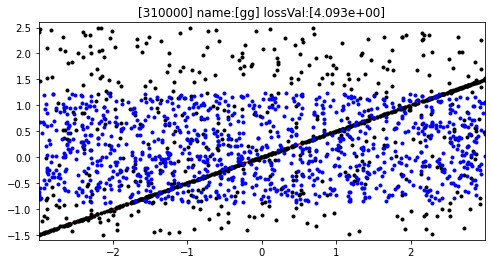

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.8510, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


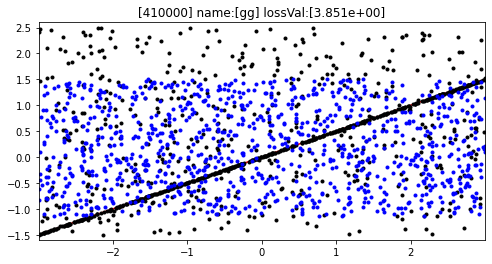

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.8036, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


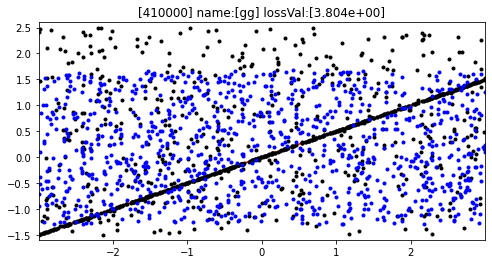

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(4.0001, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


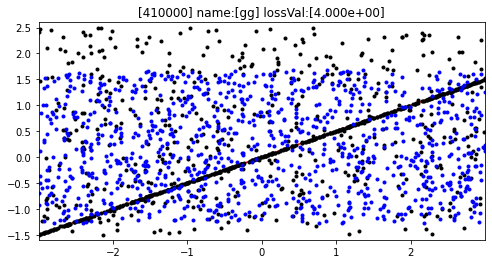

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.8695, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


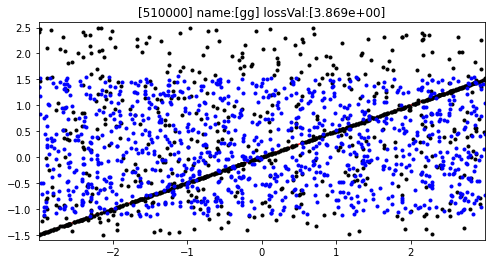

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.8287, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


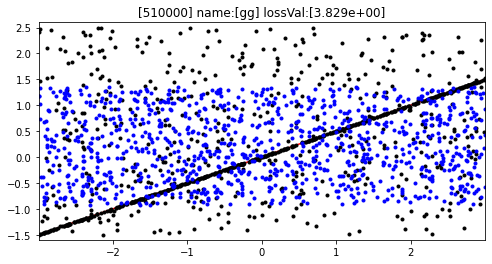

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.6381, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


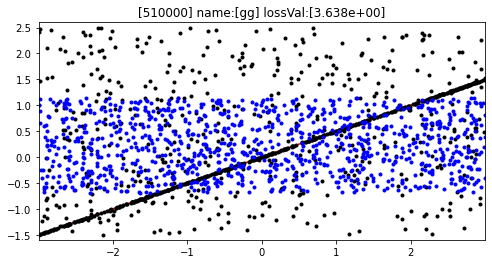

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.6693, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


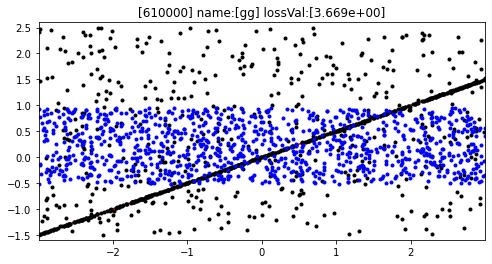

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.5912, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


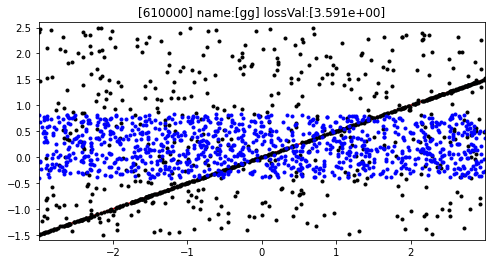

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.6455, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


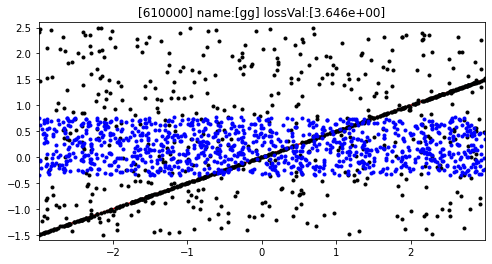

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.5802, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


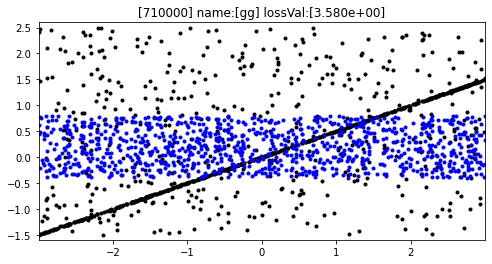

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.6456, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


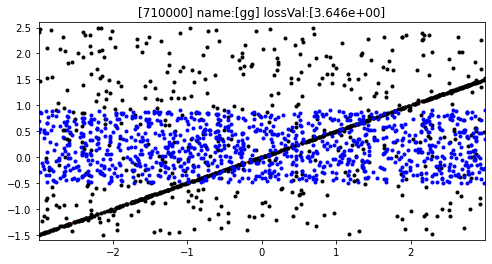

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.5591, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


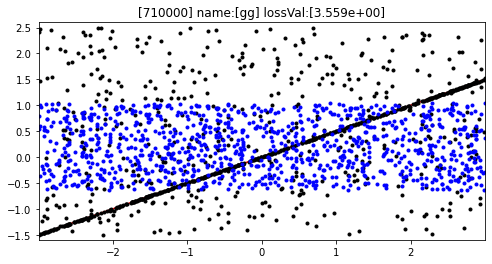

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.5794, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


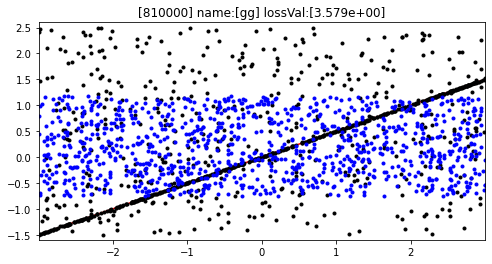

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3705, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


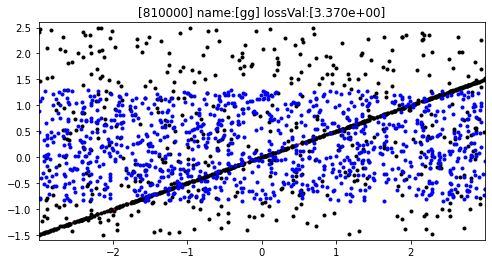

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.4970, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


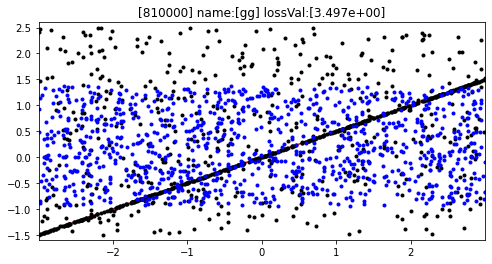

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.4962, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


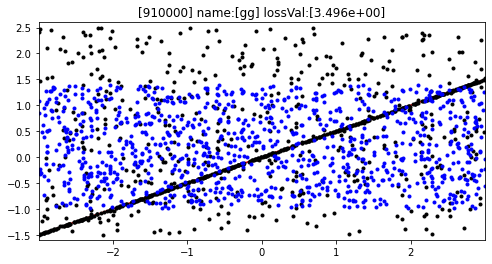

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.4053, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


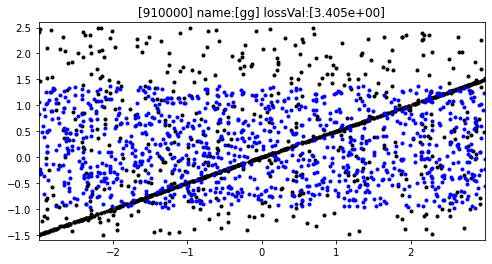

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.4525, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


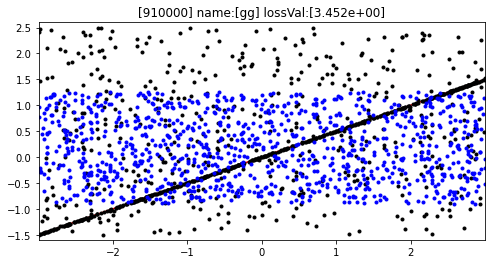

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3671, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


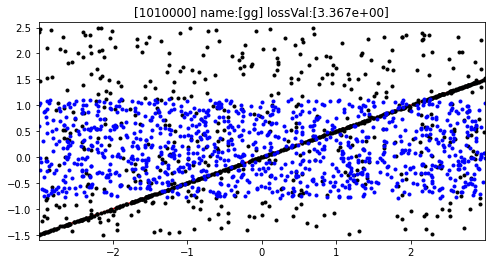

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3265, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


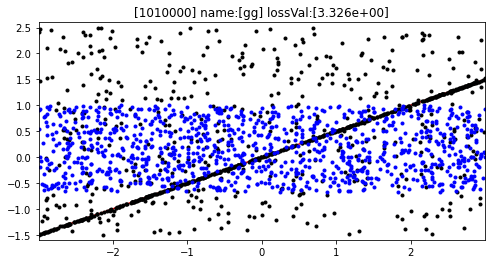

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3652, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


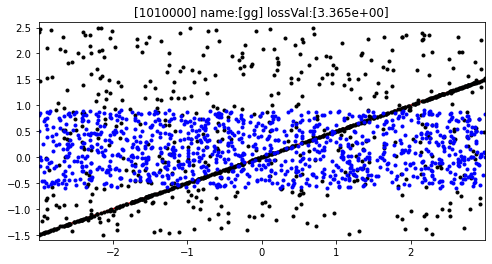

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3114, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


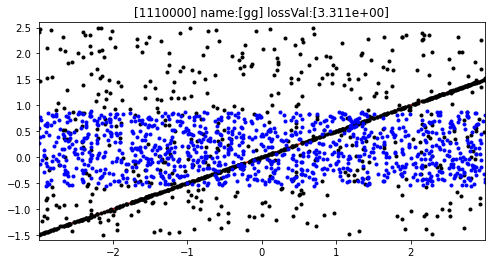

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3370, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


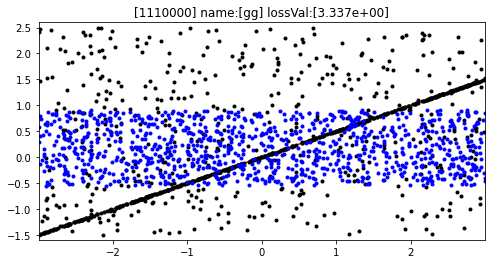

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3632, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


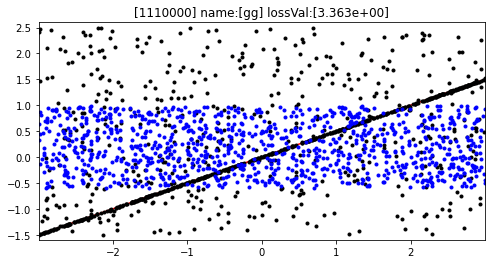

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2783, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


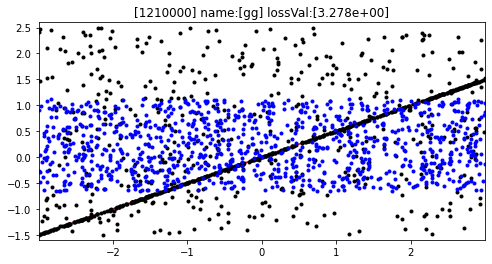

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.3569, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


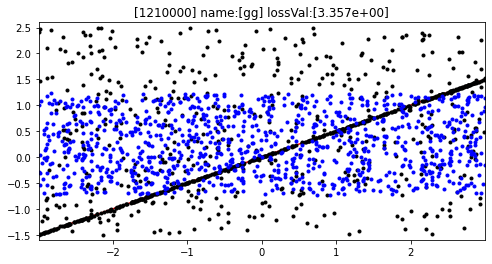

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2406, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


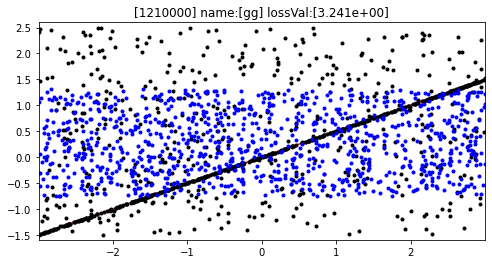

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2516, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


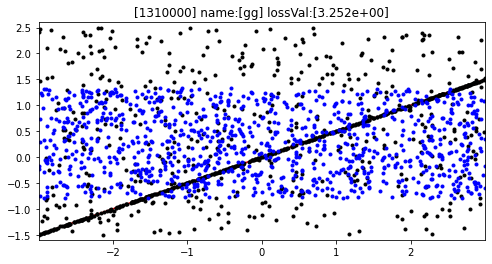

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2499, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


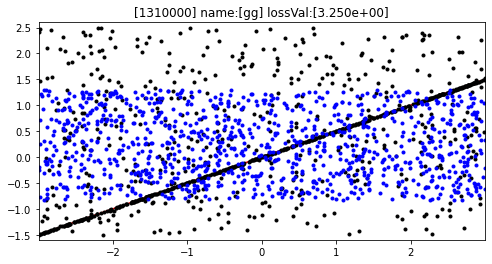

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2382, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


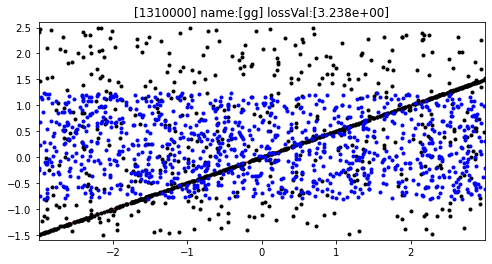

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1538, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


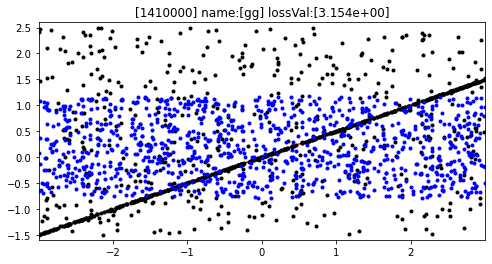

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2184, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


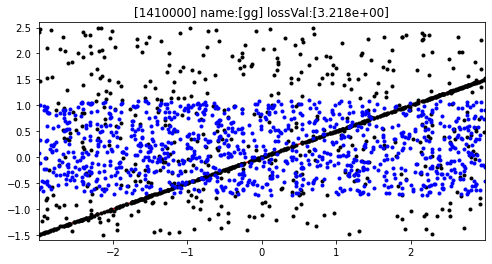

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2434, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


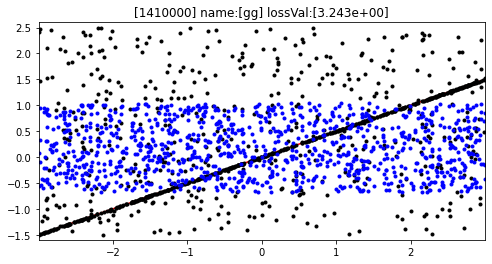

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1637, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


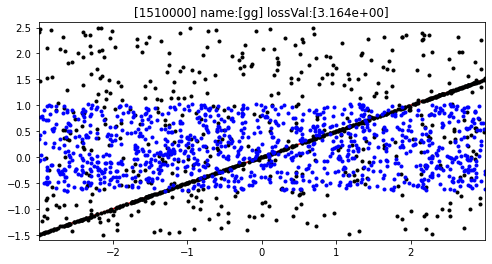

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1777, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


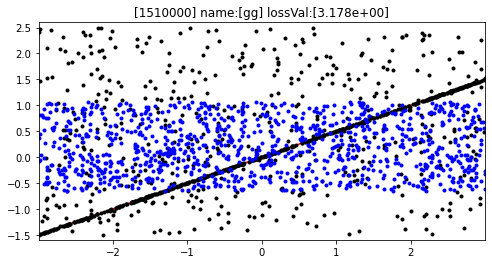

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1097, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


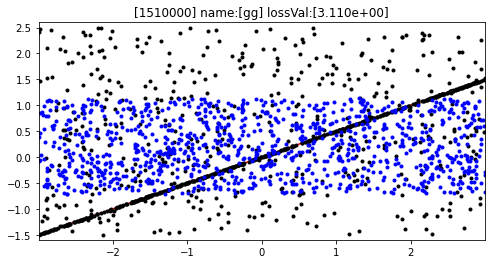

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1930, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


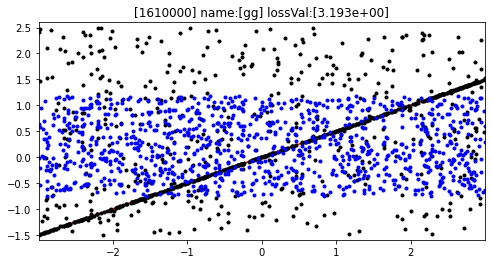

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.2086, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


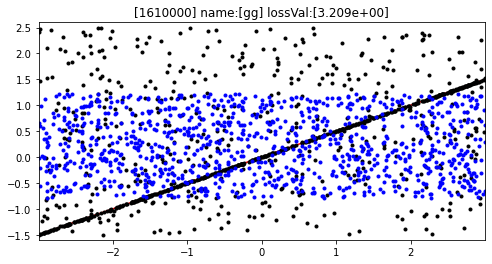

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0675, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


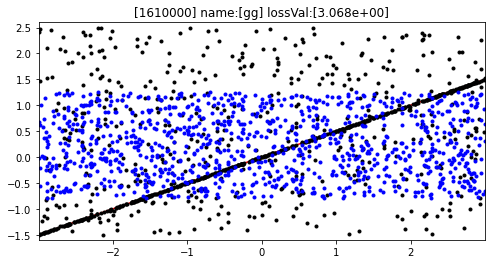

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1248, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


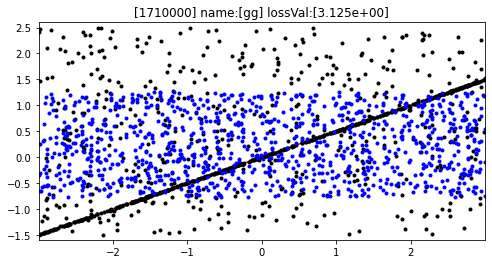

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1972, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


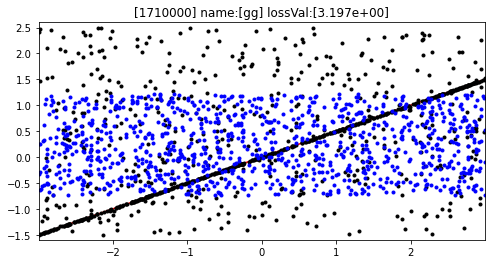

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0683, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


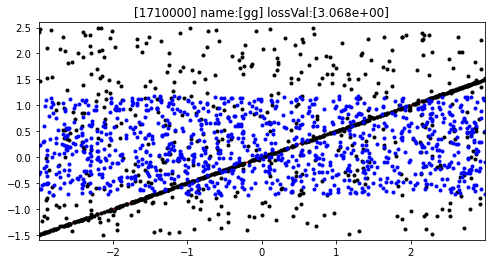

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1341, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


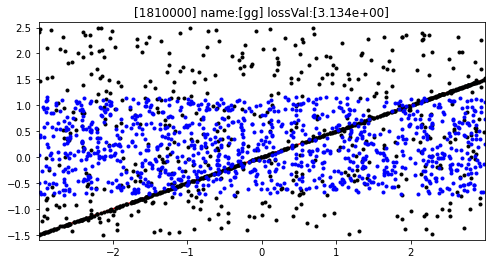

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.1042, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


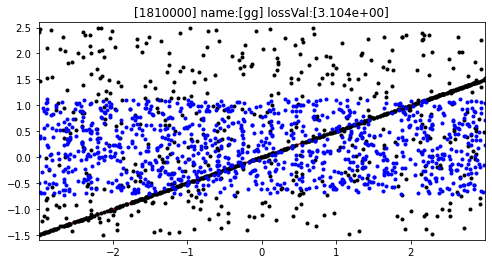

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0821, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


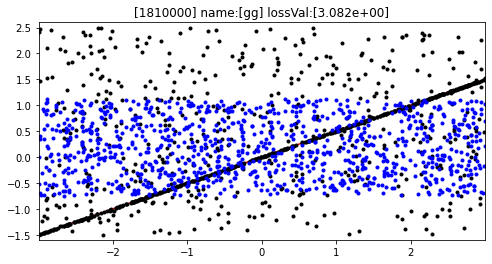

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0458, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


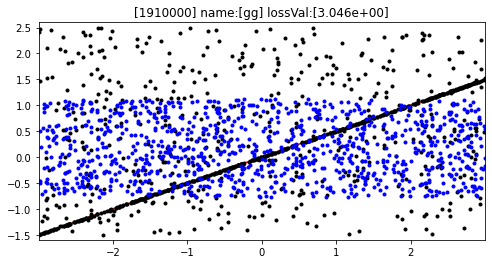

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0525, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


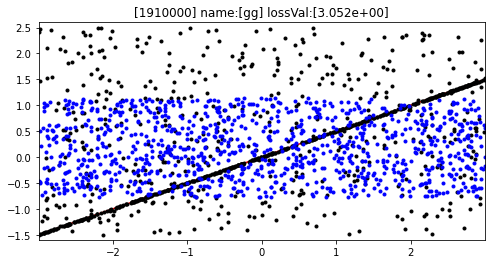

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0716, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


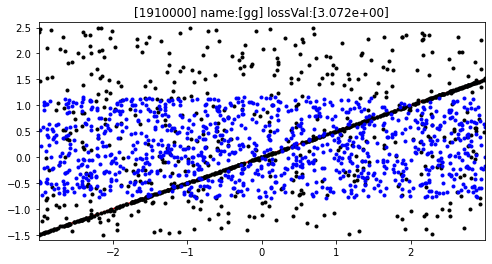

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0785, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


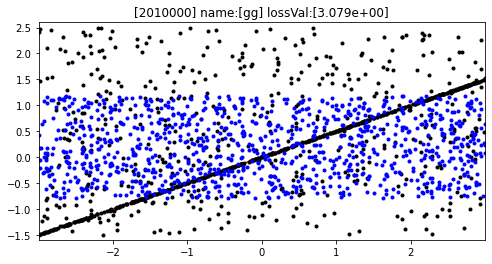

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0127, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


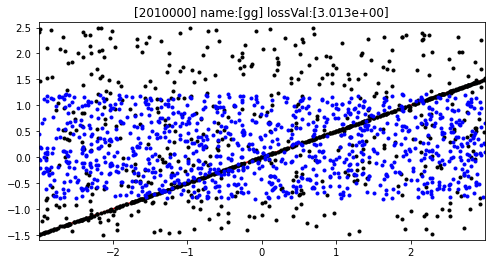

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0466, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


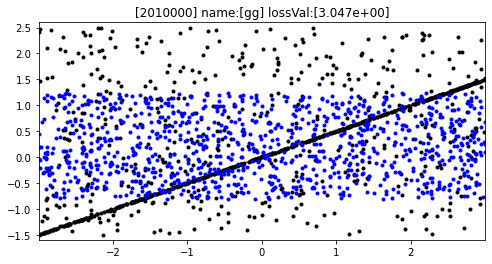

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0566, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


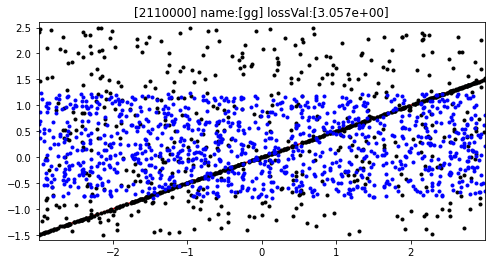

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9709, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


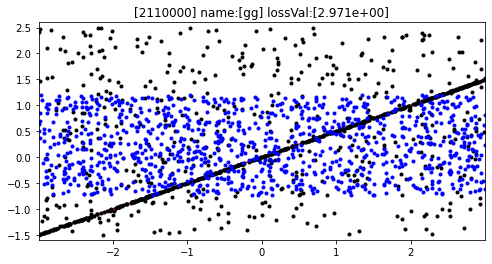

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9530, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


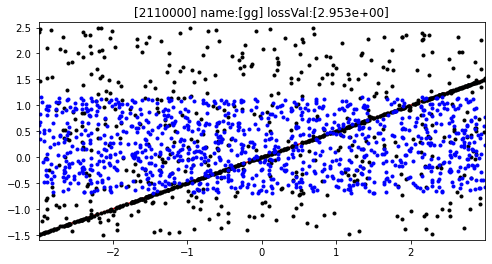

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(3.0292, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


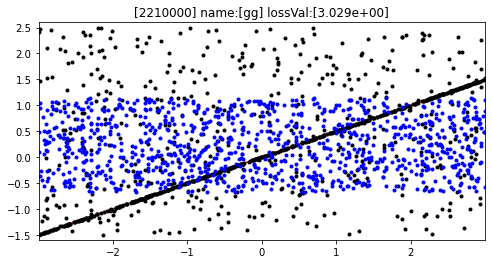

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9821, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


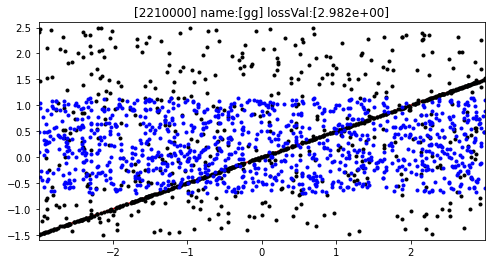

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9629, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


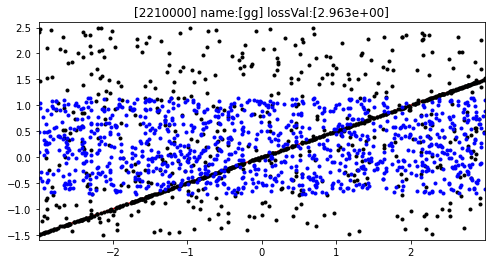

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9948, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


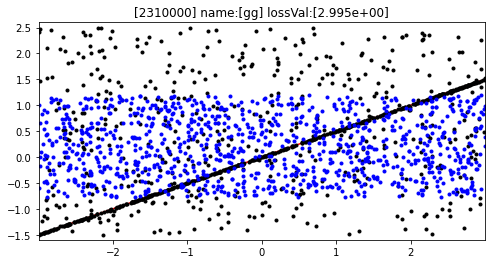

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9146, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


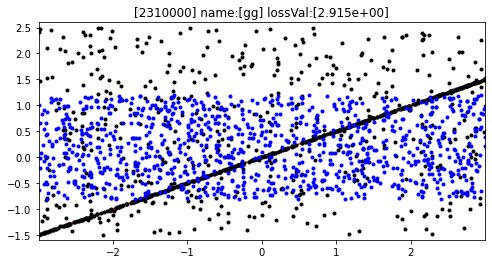

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9562, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


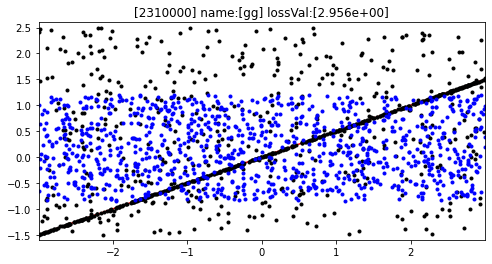

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9598, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


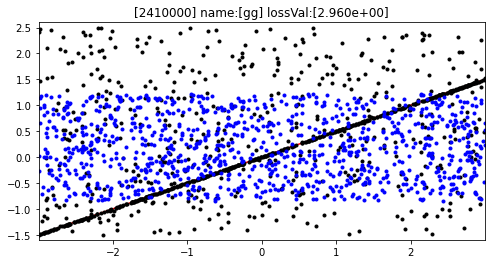

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9272, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


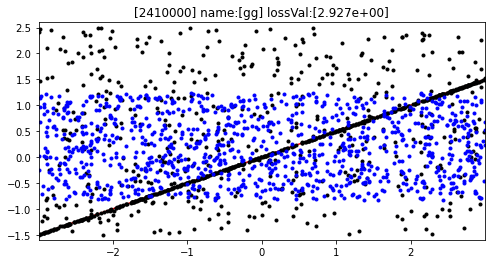

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9428, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


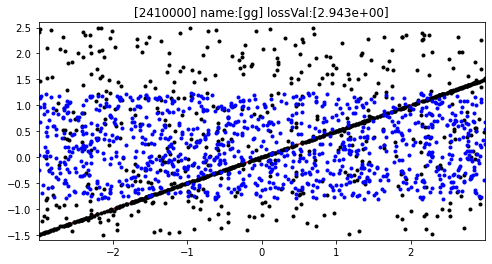

torch.Size([1000, 1000, 5])
torch.Size([1000, 1000])
tensor(2.9519, dtype=torch.float64, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


KeyboardInterrupt: ignored

In [36]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.normal(m.weight)
    #torch.nn.init.xavier_normal(m.weight)
  if type(m) == nn.Conv2d:
    torch.nn.init.normal(m.weight)
    #torch.nn.init.xavier_normal(m.weight)
dataType = 'linear'
oRate = 0.5
measVar = 1e-8

x,y,t = data4reg(_type=dataType, _n=1000, _oRange=[-1.5,2.5],_oRate=oRate,measVar=measVar)
#print(y)
xtest = np.linspace(start=-3, stop=3, num=500).reshape((-1,1))

model = ChoiceNet(x_dim=1, y_dim=1, num_mixture=5, feature_dim=32, logSigmaZval=0, tau_inv=1e-2, pi1_bias=0.0)
#model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

#summary(model(x,rho_ref=0.95),(1,1))

for name, param in model.named_parameters():
  print(name, param.requires_grad)
  # if param.requires_grad:
  #   print (name, param.data.size())
  # else :
  #   print (name, param.data.size())
train(model,_x=x, _y=y, _yref=t,batchSize=256)
# for epoch in range(1, args['epochs']+1):
#   train_overfit(epoch)
#   test()